## A look at each workflow's final HMMs

-----------
#### Plots for big-picture look for each dataset and model pipeline
- Cluster (state) centers on tica landscape or direct tica coods painted
  to indicate HMM state
- HMM implied timescales for selecting model on bottom

-------------------------------
#### Map HMM trajectory to TICA data
 - each TICA coordinate painted by state color
 - this is most detailed view of HMM partition
   on the TICA space projections

Wkf: ltj, tica_array.shape: (6490000, 2)


IndexError: list index out of range

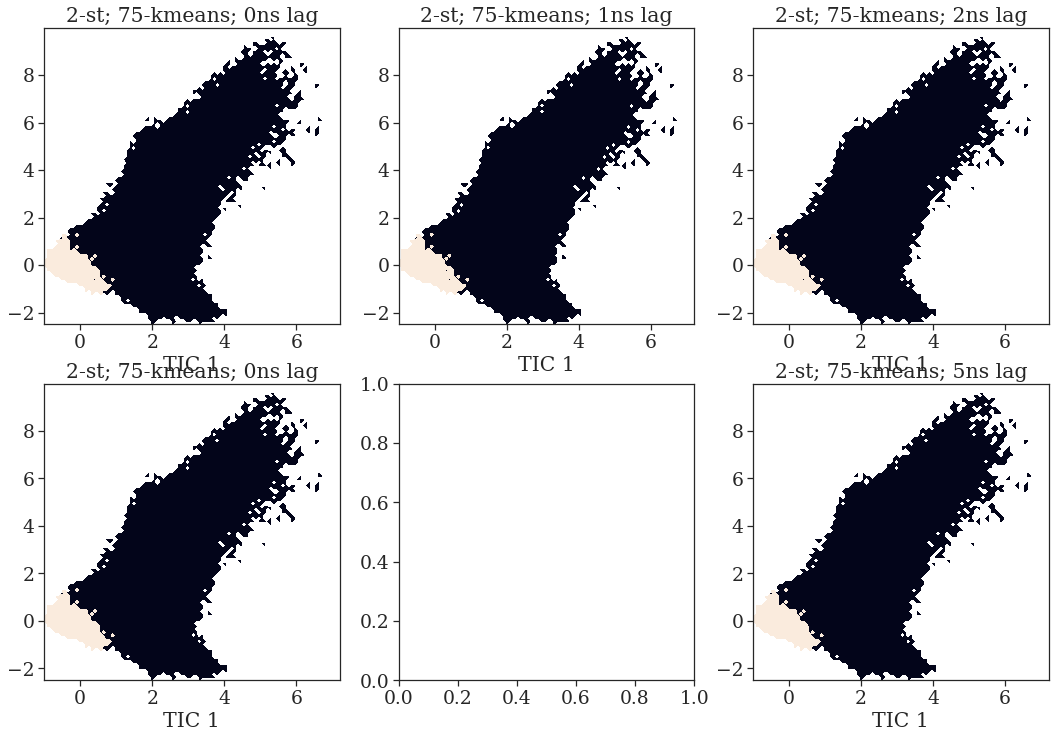

In [80]:
for feat,nm,dataset in filter(
    lambda x: (x[1] in ["umi_Ca_2","ltj"]) and (x[0] in [feat_Ca]),
    aswa_tools.iter_models(all_models)
):
    tica_inp = np.concatenate(
        aswa_tools.get_matching_input(
            dataset["tica"],
            key="lag",
            val=chosen_tica_lag
        ).get_output(list(range(2))))

    print(colorama.Back.CYAN + "Wkf: %s, tica_array.shape: %s"%(
        nm, "{}".format(tica_inp.shape)))
    
    for clust_method, setups in filter(
        lambda x: x[0] in ["kmeans","regspace"],
        dataset["hits"].items()
    ):
        
        n_configs = len(setups)
        clustpars = set()
        
        for setup in setups:
            clustpars.add(setup["par"][0][1])
        
        for p in sorted(clustpars):

            for i,setup in enumerate(sorted(filter(
                lambda x: x["par"][0][1] == p,
                setups), key=lambda x: x["par"][1][1])
            ):
                
                fig, axes = plt.subplots(
                    2,#int(n_configs/len(clustpars)),
                    3,#len(setup["result"].models),
                    figsize=(18,12),
                    #sharey="row",
                    squeeze=False,
                )
            
                try:
                    setup["result"] = pyemma.load(setup["result"]
                        ) if isinstance(setup["result"], (str,Path)
                        ) else setup["result"]
                except:
                    continue
            
                if not setup["result"]: continue
                
                placement = [
                    # Clockwise w/ lower middle as ITS plot
                    # there are luckily 5 lags/models per ITS
                    [1,0], [0,0], [0,1], [0,2], [1,2],
                ]
                for m,model in enumerate(setup["result"].models):
                
                    p,q = placement[m]
                    
                    hmm_traj = model.metastable_assignments[
                        model.discrete_trajectories_obs
                    ]

                    _, _, misc = pyemma.plots.plot_state_map(
                        *tica_inp.T,
                        hmm_traj,
                        ax=axes[p][q],
                        cbar=True if m+1 == len(
                            setup["result"].models) else False,
                    )

                    plot_title = "%d-st;" % (
                        setup["result"].models[0].nstates)
                    plot_title += " %d-%s;" % (
                        np.unique(model.discrete_trajectories_obs
                        ).shape[0], clust_method)
                    plot_title += " %dns lag" % (
                        int(model.lag / step_per_ns[label_longtraj]))

                    axes[p][q].set_title(plot_title)
                    axes[p][q].set_xlabel("TIC 1")
                    
                pyemma.plots.plot_implied_timescales(
                    setup["result"],
                    ax=axes[1][1],
                    units='ns',
                    dt=0.02,
                )
        
                misc['cbar'].set_ticklabels(range(1, model.nstates + 1))
                axes[0][0].set_ylabel("TIC 2")
                axes[1][0].set_ylabel("TIC 2")

                plt.suptitle(
    "%s: MSMs after %s clustering in %d-TICA space from %s features"%(
        nm, clust_method, n_tica_dim, feat), fontsize=22,
                )
                fig.tight_layout(rect=[0, 0, 1, 0.95])
                plt.savefig(
    "analyses/%s/hmm/its_%dstates_%s-%d_%s-TICA01paintbystate.png"%(
        nm, setup["result"].models[0].nstates, clust_method,
        np.unique(model.discrete_trajectories_obs).shape[0], feat),
                    dpi=400)
                #break
            #break
        #break                
    #break  # for fast prototyping

-------------------
#### HMM assignment of microstates

In [ ]:
for feat,nm,dataset in filter(
    lambda x: (x[1] in ["umi_Ca_2","ltj"]) and (x[0] in [feat_Ca]),
    aswa_tools.iter_models(all_models)
):
    
    tica_inp = np.array(np.concatenate(
        aswa_tools.get_matching_input(
            dataset["tica"],
            key="lag",
            val=chosen_tica_lag
        ).get_output(list(range(2)))
    ))
    
    for clust_method, setups in filter(
        lambda x: x[0] in ["kmeans"],
        dataset["hits"].items()
    ):
        n_configs = len(setups)
        clustpars = set()
        
        for setup in setups:
            clustpars.add(setup["par"][0][1])
        
        for p in sorted(clustpars):

            for i,setup in enumerate(sorted(filter(
                lambda x: x["par"][0][1] == p,
                setups), key=lambda x: x["par"][1][1])
            ):
                
                fig, axes = plt.subplots(
                    1,#int(n_configs/len(clustpars)),
                    len(setup["result"].models),
                    figsize=(5*len(setup["result"].models),
                             #4*int(n_configs/len(clustpars))),
                             6),
                    sharey="row",
                    squeeze=False,
                )
            
                try:
                    setup["result"] = pyemma.load(setup["result"]
                        ) if isinstance(setup["result"], (str,Path)
                        ) else setup["result"]
                except:
                    continue
            
                if not setup["result"]: continue

                clustercenters = aswa_tools.get_matching_input(
                    dataset["cluster_%s"%clust_method],
                    key=setup["par"][0][0],
                    val=setup["par"][0][1]
                ).clustercenters

                for m,model in enumerate(setup["result"].models):

                    pyemma.plots.plot_free_energy( 
                    #pyemma.plots.plot_density(
                        *tica_inp.T,
                        cbar=False,
                        alpha=0.8,
                        ax=axes[0][m],
                        logscale=True,
                        cmap="RdYlGn_r",
                    )


                    # TODO color by step number of initial visit
                    cccc = cmap(plt.Normalize()(list(range(model.nstates))))
                    
                    for n in range(model.nstates):
                        seaborn.scatterplot(
                            x=clustercenters[model.metastable_sets[n],0],
                            y=clustercenters[model.metastable_sets[n],1],
                            s=135,
                            ax=axes[0][m],
                            #legend=False,
                            color=cccc[n],
                            linewidth=0,
    #                        label="S %d"%(n+1),
                        )

                    plot_title = "%d-st;"%(setup["result"].nits+1)
                    plot_title += " %d-cl-%s;" % (clustercenters.shape[0], clust_method)
                    plot_title += " %dns lag" % int(model.lag / step_per_ns[label_longtraj])

                    axes[0][m].set_title(plot_title)
                    axes[0][m].set_xlabel("TIC 1")

  #              axes[0][-1].legend(
   #                 loc="upper right",
    #                fontsize=16,
     #           #    ncol=2,
      #          #    handlelength=0.5,
       #         )
        
                axes[0][0].set_ylabel("TIC 2")

                plt.suptitle(
                    "%s: MSMs after %s clustering in %d-TICA space from %s features"%(
                        nm, clust_method, n_tica_dim, feat), fontsize=22,
                )
                fig.tight_layout(rect=[0, 0, 1, 0.95])
                plt.savefig("analyses/%s/hmm/its_%dstates_%s-%s-TICA01landscapewithCC.png"%(
                    nm, setup["result"].models[0].nstates, clust_method, feat), dpi=600)
                
    #break  # for fast prototyping

----------------------------


Cherry-picked model with best HMM microstate assignments and ITS

In [ ]:
for feat,nm,dataset in filter(
    lambda x: (x[1] in ["umi_Ca_2","ltj"]) and (x[0] in [feat_Ca]),
    aswa_tools.iter_models(all_models)
):
    
    tica_inp = np.array(np.concatenate(
        aswa_tools.get_matching_input(
            dataset["tica"],
            key="lag",
            val=chosen_tica_lag
        ).get_output(list(range(2)))
    ))
    
    for clust_method, setups in dataset["hits"].items():
        
        n_configs = len(setups)
        clustpars = set()
        
        for setup in setups:
            clustpars.add(setup["par"][0][1])
        
        for p in sorted(clustpars):
            
            fig, axes = plt.subplots(2, int(n_configs/len(clustpars)),
                figsize=(4*int(n_configs/len(clustpars)), 9), sharey="row")

            for i,setup in enumerate(sorted(filter(
                lambda x: x["par"][0][1] == p,
                setups), key=lambda x: x["par"][1][1])
            ):
            
                try:
                    setup["result"] = pyemma.load(setup["result"]
                        ) if isinstance(setup["result"], (str,Path)
                        ) else setup["result"]
                except:
                    continue
            
                if not setup["result"]: continue

                clustercenters = aswa_tools.get_matching_input(
                    dataset["cluster_%s"%clust_method],
                    key=setup["par"][0][0],
                    val=setup["par"][0][1]
                ).clustercenters

                pyemma.plots.plot_free_energy( 
                #pyemma.plots.plot_density(
                    *tica_inp.T,
                    cbar=False,
                    alpha=0.8,
                    ax=axes[0][i],
                    logscale=True,
                    cmap="RdYlGn_r",
                )

                seaborn.scatterplot(
                    x=clustercenters[:,0],
                    y=clustercenters[:,1],
                    s=35,
                    ax=axes[0][i],
                    legend=False,
                    color="blue",
                    linewidth=0,
                )
                plot_title = "%d-st;"%(setup["result"].nits+1)
                plot_title += " %d-cl-%s" % (clustercenters.shape[0], clust_method)

                axes[0][i].set_title(plot_title)
                axes[0][i].set_xlabel("TIC 1")
                #axes[1][i].set_ylim([0.5,2000])

                if i == 0:
                    axes[0][i].set_ylabel("TIC 2")

                pyemma.plots.plot_implied_timescales(
                    setup["result"],
                    ax=axes[1][i],
                    units='ns', dt=0.02,
                )
                
                axes[1][i].minorticks_on()

                if i > 0:
                    axes[1][i].yaxis.label.set_visible(False)
                    #axes[2,i].yaxis.label.set_visible(False)

                #break  # to run faster while prototyping

            plt.suptitle(
                "%s: MSMs after %s clustering in %d-TICA space from %s features"%(
                    nm, clust_method, n_tica_dim, feat), fontsize=22,
            )
            fig.tight_layout(rect=[0, 0, 1, 0.95])
            plt.savefig("analyses/%s/hmm/its_%dstates_%s-%s-TICA01landscapewithCC.png"%(
                nm, setup["result"].models[0].nstates, clust_method, feat), dpi=600)

---------------

-----------------

-----------------

-----------------

-----------------

-----------------

-----------------

-----------------

-----------------